In [2]:
import torch
import requests

#! wget https://owncloud.gwdg.de/index.php/s/ioHbRzFx6th32hn/download -O weights.zip
#! unzip -d weights -j weights.zip
from models.clipseg import CLIPDensePredT
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt

# load model
model = CLIPDensePredT(version='ViT-B/16', reduce_dim=64)
model.eval()

# non-strict, because we only stored decoder weights (not CLIP weights)
model.load_state_dict(torch.load('/export/livia/home/vision/Rbhattacharya/work/clipseg/weights/clipseg_weights/rd64-uni.pth', map_location=torch.device('cpu')), strict=False)

/tmp/ipykernel_3343556/1174470681.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/export/livia/home/vision/Rbhattacharya/work/clipseg

_IncompatibleKeys(missing_keys=['clip_model.positional_embedding', 'clip_model.text_projection', 'clip_model.logit_scale', 'clip_model.visual.class_embedding', 'clip_model.visual.positional_embedding', 'clip_model.visual.proj', 'clip_model.visual.conv1.weight', 'clip_model.visual.ln_pre.weight', 'clip_model.visual.ln_pre.bias', 'clip_model.visual.transformer.resblocks.0.attn.in_proj_weight', 'clip_model.visual.transformer.resblocks.0.attn.in_proj_bias', 'clip_model.visual.transformer.resblocks.0.attn.out_proj.weight', 'clip_model.visual.transformer.resblocks.0.attn.out_proj.bias', 'clip_model.visual.transformer.resblocks.0.ln_1.weight', 'clip_model.visual.transformer.resblocks.0.ln_1.bias', 'clip_model.visual.transformer.resblocks.0.mlp.c_fc.weight', 'clip_model.visual.transformer.resblocks.0.mlp.c_fc.bias', 'clip_model.visual.transformer.resblocks.0.mlp.c_proj.weight', 'clip_model.visual.transformer.resblocks.0.mlp.c_proj.bias', 'clip_model.visual.transformer.resblocks.0.ln_2.weight',

Load and normalize `example_image.jpg`. You can also load through an URL.

In [3]:
# load and normalize image
input_image = Image.open('/export/livia/home/vision/Rbhattacharya/work/data/data/msmt17/MSMT17/train/0001/0001_002_01_0303morning_0030_3_ex.jpg')

# or load from URL...
# image_url = 'https://farm5.staticflickr.com/4141/4856248695_03475782dc_z.jpg'
# input_image = Image.open(requests.get(image_url, stream=True).raw)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Resize((352, 352)),
])
print(input_image.size)
img = transform(input_image).unsqueeze(0)

(50, 142)


Predict and visualize (this might take a few seconds if running without GPU support)

torch.Size([6, 1, 352, 352])


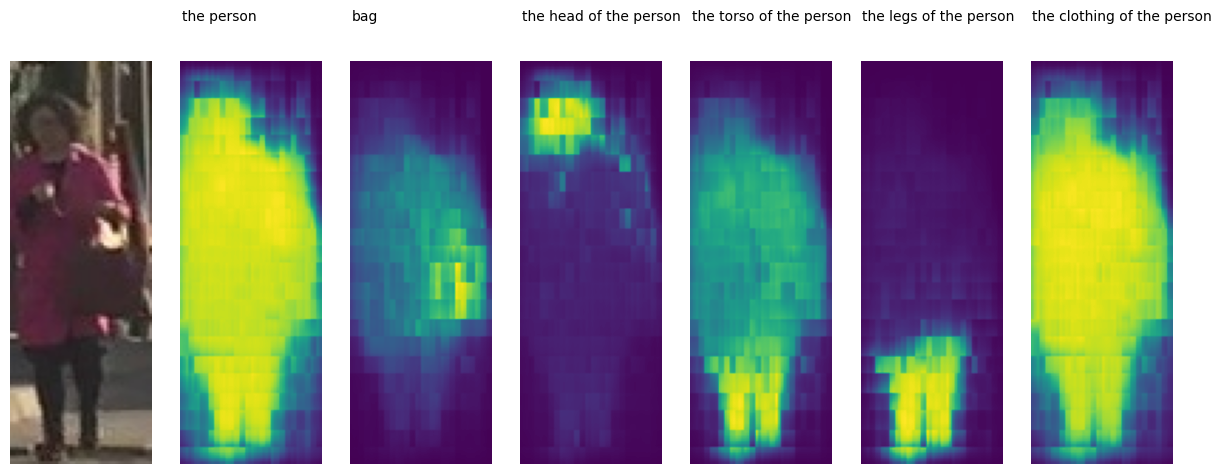

In [4]:
import torch.nn.functional as F
prompts = ['the person', 'bag', 'the head of the person', 'the torso of the person', 'the legs of the person', 'the clothing of the person']

# predict
with torch.no_grad():
    preds = model(img.repeat(len(prompts),1,1,1), prompts)[0]
    print(preds.shape)
    preds = F.interpolate(preds, (input_image.size[1], input_image.size[0]))

# visualize prediction
_, ax = plt.subplots(1, 1+len(prompts), figsize=(15, len(prompts)))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(input_image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompts[i]) for i in range(len(prompts))];

torch.Size([6, 1, 352, 352])
torch.Size([6, 3, 142, 50])


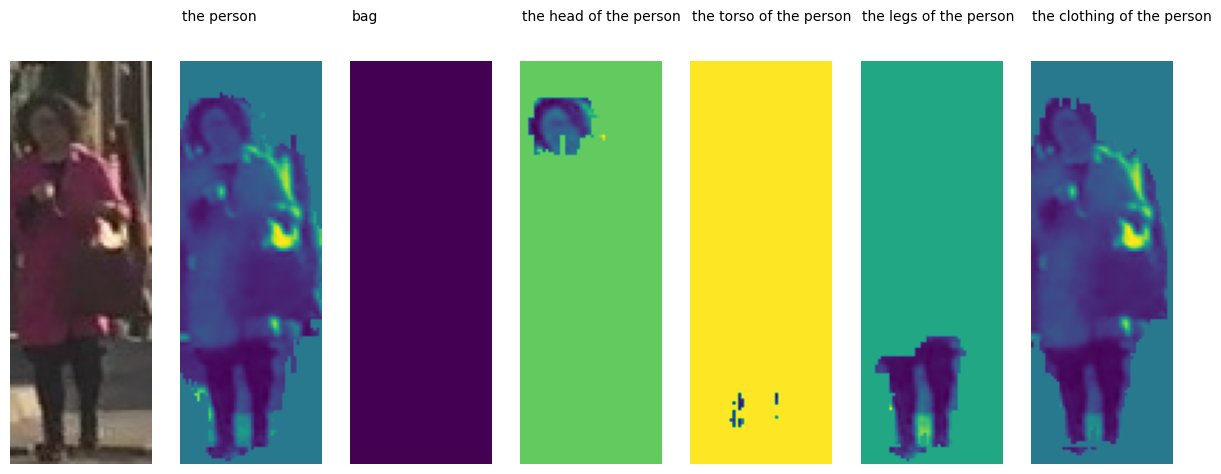

In [ ]:
prompts = ['the person', 'bag', 'the head of the person', 'the torso of the person', 'the legs of the person', 'the clothing of the person']
thresh = 0.5
# predict
with torch.no_grad():
    preds = model(img.repeat(len(prompts),1,1,1), prompts)[0]
    print(preds.shape)
    imgs = F.interpolate(img.repeat(len(prompts),1,1,1), (input_image.size[1], input_image.size[0]))
    preds = F.interpolate(preds, (input_image.size[1], input_image.size[0]))
    preds = torch.sigmoid(preds)
    preds[preds >= thresh] = 1.0
    preds[preds < thresh] = 0.0

    masked_imgs = imgs * preds
    masked_imgs = masked_imgs.detach().cpu().numpy()
print(masked_imgs.shape)
# visualize prediction
_, ax = plt.subplots(1, 1+len(prompts), figsize=(15, len(prompts)))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(input_image)
[ax[i+1].imshow(masked_imgs[i][0]) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompts[i]) for i in range(len(prompts))];